# Deep Tabla

Deep Tabla is AI powered tabla accompaniment. It is based on recurrent neural network. 

This implementation is based on Tensorflow.

## Background

### Basics of Tabla

Tabla is a north Indian percussion instrument. It comprises of two drums played together. 

Tabla is a unique percussion instrument and can produce extremely rich and advanced percussion improvisations. This is so because like human languages, Tabla has its own language. Various sounds on each drum have their own naming convention like alphabets in English. A combination of alphabets form words, a combination of words form sentences and sentences spoken with accent form compositions.

An example of a 16 beat "sentence" in tabla could be - "Dha Dhin Dhin Dha Dha Dhin Dhin Dha Dha Tin Tin Ta Ta Dhin Dhin Dha". The word "Dha" itself comprises of two alphabets - "Ta" played on left (smaller) drum and "Ge" played on right (bigger) drum.

More information on tabla can be found here.

https://www.youtube.com/watch?v=nJFO9UxQW8o
https://www.youtube.com/watch?v=fbIm5y0pxr8

### Teentaal

Teentaal is a very common rhythmic cycle of 16 beats. It is characterised by the following -

1. The first beat is called "sam" (pronounced as "sum"). It is the emphasis beat and a good tabla player would show it distinctly during the course of improvisation.

2. The cycle of 16 beats is divided into four segments of four beats. The third of the four segments - i.e. beats 9, 10, 11, 12 - is called "khali" and is presented in a peculier way. Even in the course of improvisation, a good tabla plays this segment in a distinct way.

Teentaal has its basic structure - "Dha Dhin Dhin Dha Dha Dhin Dhin Dha Dha Tin Tin Ta Ta Dhin Dhin Dha". However, in a real concert a good tabla accompanist would not play it this plainly. A good tabla player would improvise this cycle, taking influences from his own training and from the main artist. During the course of improvisation, the tabla player would create percussion freely while maintaining the rules indicated above. An example of this interaction can be seen here.

https://www.youtube.com/watch?v=LZ8BJfU-7t8

### AI Tabla - What is Success

Here are a few things AI tabla should be able to do to claim success -

1. Maintain the cyclicity of beats in the rhythmic cycle. If playing Teentaal which is of 16 beats, the AI should predictably play 16 beats with highest certainty all the time. It should never play 15 or 17 or 13 or any other number of beats in a cycle.

2. It should show emphasis on the first beat ("sam")

3. It should show the khali beats (3rd segment of 4 beats as explained above) appropriately.

4. It should be as original as possible. Much of its improvisation should be original. i.e. it should not simply copy cycles from training data.

For the purpose of demo below, the training dataset is comprised of millions of cycles of 16 beats. It has the first beat in all upper case letters to denote its distinction. It also has the improvised version of 3rd segment throughout.



## Import Necessary Libraries

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
tf.set_random_seed(0)  

print ("Tensorflow version is %s" % (tf.__version__))
print ("Pandas version is %s" % (pd.__version__))
print ("Numpy version is %s" % (np.__version__))


Tensorflow version is 1.0.0
Pandas version is 0.20.1
Numpy version is 1.12.1


## Set Execution Parameters

This notebook runs in multiple modes. This section sets parameters for behavior of this notebook.

In [2]:
# Create Training Data based on cycle (repeat the cycle multiple times) (enter number of training records) 
# or import training data from file (0)
# We of course know that repeating training data multiple times does not yield in any additional training
# That option is available just for testing

use_of_training_data = 0

# If training data is being generated, define cycle which will be repeated to generate it
cycle = ("Dha Dhin Dhin Dha Dha Dhin Dhin Dha Dha Tin Tin Ta Ta Dhin Dhin Dha ")

cycle2 = ("Dha - Dhin Dha Dha - Dhin Dha Dha - Tin Ta Ta - Dhin Dha ")
cycle3 = ("Dha Dhin Dhin Dha Dha GeNa Dhin Dha Dha Tin Tin Ta Traka Dhin Dhin Dha ")
cycle4 = ("DhaGe Dhin Dhin Dha DhaGe Dhin Dhin Dha DhaGe Tin Tin Ta Traka Dhin Dhin Dha ")

# Create variations in training data
randomize_training_data = 0

# Data file
dataset_file = './data/Teentaal.txt'

# Output file
output_file = './data/MachineTeentaal.txt'

# Model Saved file
model_file = './model/DeepTabla.ckpt'

# Iterations for Training (longer the better but will take time)
training_iterations = 500

# size of hidden layer
hidden_size     = 128

# Training Sequential (nonzero) or Random (0)
trg_seq = 1

# size of each training batch
sequence_length = 16  # multiples of cycle? will it matter?

# batch size
batch_size = 800

# learning rate
lrate = 0.01

# output length - number of bols you want trained RNN to generate
output_length = 5000

## Generate or Import Training Sequence

Depending on parameter set above, this step generates training sequence or imports it from a file.

In [3]:
if use_of_training_data > 0:

    print ("Generating Training Data Based on Cycle :")
    print (cycle)

    sentence = ''
    # convert sentence into a huge training dataset
    for i in range(use_of_training_data):
        sentence = sentence + cycle
        sentence = sentence + cycle2
        sentence = sentence + cycle3
        sentence = sentence + cycle4
        
    print ("Training Sequence Generated.")

elif use_of_training_data == 0:
    print ("Importing Training Data From Training File :", dataset_file)
    sentence = open(dataset_file).read()
    print(sentence[0:80])

    print ("Training Sequence Imported.")
else:
    print ("Incorrect use_of_training_data parameter.")

    
sentence = sentence.replace('\t',' ')


Importing Training Data From Training File : ./data/Teentaal.txt
NA	Dhin	Dhin	Dha	Dha	Dhin	-	Dha	Dha	Tin	Tin	Ta	TraKa	Dhin	Dhin	Dha 
DHAKITA	Dhin
Training Sequence Imported.


## Profile Training Data

Explore training data statistics.

In [4]:
print ("\nLength of Training Sequence Is:", len(sentence))
print ("Number of Cycles in Training Sequence:", sentence.count('\n'))
print ("Number of Bols in Training Sequence:", sentence.count(' '))
print ("Reconcile bols per cycle (should be 16 for teentaal):", sentence.count(' ')/sentence.count('\n'))



Length of Training Sequence Is: 136078418
Number of Cycles in Training Sequence: 1680000
Number of Bols in Training Sequence: 26880000
Reconcile bols per cycle (should be 16 for teentaal): 16.0


In [5]:
df = pd.read_csv(dataset_file, sep='\t', header=None)
df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,NaN,Dhin,Dhin,Dha,Dha,Dhin,-,Dha,Dha,Tin,Tin,Ta,TraKa,Dhin,Dhin,Dha
1,DHAKITA,Dhin,Dhin,Dha,DhaGe,Dhin,Dhin,Dha,DhaDha,Tin,Tin,Ta,NaNaNa,Dhin,Dhin,Dha
2,DHADHA,Dhin,Dhin,Dha,DhaGe,Dhin,-,Dha,DhaGeNa,Tin,Tin,TaTa,Ta,Dhin,Dhin,Dha
3,DHA,Traka,Dhin,Dha,Dha,DhinaKe,-,Dha,DhaGe,Tin,Tin,Ta,TraKa,Dhinaka,Dhin,Na
4,DHAKITA,Traka,Dhin,Dha,DhaKiTa,Dhin,Dhin,Dha,DhaGeNa,Tin,Tin,Ta,Ta,Dhin,Dhin,Dha


In [6]:
df.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,1512349,1680000,1680000,1680000,1680000,1680000,1680000,1680000,1680000,1680000,1680000,1680000,1680000,1680000,1680000,1680000
unique,6,4,3,4,7,4,3,4,4,3,4,3,6,3,4,4
top,DHA,Dhin,Dhin,Dha,Dha,Dhin,Dhin,Dha,DhaGeNa,Tin,Tin,Ta,Ta,Dhin,Dhin,Dha
freq,671688,1175716,1343796,1176063,671984,1176435,1343656,1175808,1007753,1343600,1174782,1344676,840419,1343841,1176036,1175288


## Define Vocabulary and Dictionary

This step analyzes training sequence for unique bols of tabla (vocabulary) and assigns unique number to each bol so that it can be used for vectorization process.

Neural network does not know what these bols are. It needs to think numbers. Hence we have to transform the input to the language of numbers and output from numbers back to bols.

In [7]:
# split the text
char_set = list(set(sentence.split()))
char_set = sorted(char_set,key=len,reverse=True)

# create dictionary - 1 number for each bol
char_dic = {w: i for i, w in enumerate(char_set)}

print ("Vocabulary (Unique bols): ")
print (char_set)
print ("\nDictionary (Unique bols with each assigned unique number): ")
print (char_dic)

# preserve the dictionary and vocabulary for eventual decoding of the output of neural network.
bols_set = char_set
bols_dic = char_dic

Vocabulary (Unique bols): 
['DhinDhin', 'NaNaNaNa', 'DhaKiTa', 'DhaGeNa', 'DHAKITA', 'Dhinaka', 'DhinaKe', 'DhaDha', 'TinaKa', 'DHADHA', 'NaNaNa', 'TinTin', 'Traka', 'DHAGE', 'DhiNa', 'DhaGe', 'DHINA', 'TraKa', 'NaNa', 'TiTa', 'Dhin', 'NaNA', 'NANA', 'TaTa', 'Tin', 'DHA', 'Dha', 'Na', 'Ta', 'NA', '-']

Dictionary (Unique bols with each assigned unique number): 
{'DhinDhin': 0, 'NaNaNaNa': 1, 'DhaKiTa': 2, 'DhaGeNa': 3, 'DHAKITA': 4, 'Dhinaka': 5, 'DhinaKe': 6, 'DhaDha': 7, 'TinaKa': 8, 'DHADHA': 9, 'NaNaNa': 10, 'TinTin': 11, 'Traka': 12, 'DHAGE': 13, 'DhiNa': 14, 'DhaGe': 15, 'DHINA': 16, 'TraKa': 17, 'NaNa': 18, 'TiTa': 19, 'Dhin': 20, 'NaNA': 21, 'NANA': 22, 'TaTa': 23, 'Tin': 24, 'DHA': 25, 'Dha': 26, 'Na': 27, 'Ta': 28, 'NA': 29, '-': 30}


## Encode Bols to Numbers

This step translates tabla bols in the training string to numbers assigned to them in the dictionary above.

In [8]:
print ("Encoding bols to numbers....")

# remove all newlines
sentence = sentence.replace('\n','')


new_sentence = sentence
new_cycle = cycle

print ('Starting\t:', new_sentence[0:80])


# Replace Words in sentence strings with Dictionary numbers
for i in range(0,len(char_set)):
    new_sentence = new_sentence.replace(list(char_set)[i],str(i))
    new_cycle = new_cycle.replace(list(char_set)[i],str(i))
    print (i, list(char_set)[i], '\t:', new_sentence[0:80])

sentence = new_sentence

# split the text
sentence_set = list(set(sentence.split()))

# create dictionary - 1 number for each bol
sentence_dic = {w: i for i, w in enumerate(sentence_set)}

char_set = sentence_set
char_dic = sentence_dic

print ('\nVectorized Training Set (first 80 charactors):\n', sentence[0:80])

print ('\nBols Encoded.')

Encoding bols to numbers....
Starting	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha DHAKITA Dhin 
0 DhinDhin 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha DHAKITA Dhin 
1 NaNaNaNa 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha DHAKITA Dhin 
2 DhaKiTa 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha DHAKITA Dhin 
3 DhaGeNa 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha DHAKITA Dhin 
4 DHAKITA 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha 4 Dhin Dhin D
5 Dhinaka 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha 4 Dhin Dhin D
6 DhinaKe 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha 4 Dhin Dhin D
7 DhaDha 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha 4 Dhin Dhin D
8 TinaKa 	: NA Dhin Dhin Dha Dha Dhin - Dha Dha Tin Tin Ta TraKa Dhin Dhin Dha 4 Dhin Dhin D
9 DHADHA 	: NA Dhin Dhin Dha Dha 

## Configure Recurrent Neural Network (RNN) - Set Parameters

Set RNN parameters

In [9]:
#
data_dim    = len(char_set)

# number of classes - same as number of bols in training sequence
num_classes = len(char_set)


## Set Training Batches

Recurrent Neural Networks train on data sequence. Here we are going to break the training sequence in chunks of sequence length. Independent variable (X) and dependent variable (Y) will be offset by 1 beat. The idea is that clues exist in X dataset that resulted in Y dataset and network will learn from those clues.

In [10]:
dataX = []
dataY = []

# Convert sentence into list and pop out last newline
listsentence = sentence.split(' ')
del listsentence[-1]

print ('Beginning to set training batches.')
for i in range(0, len(listsentence) - sequence_length):

    x_str = listsentence[i:i+sequence_length]
    y_str = listsentence[i + 1:i+sequence_length + 1]
    
    x = [int(i) for i in x_str]
    y = [int(i) for i in y_str]
    
    dataX.append(x)
    dataY.append(y)
    
    if (i%(len(listsentence)/10000)) == 0:
        print ("[%3d %%] Complete." % (i/len(listsentence)*100), end = '\r')

ndata      = len(dataX)

print ("     'NData' is %d" % (ndata))
print ("'Batch Size' is %d" % (batch_size))

print ("\nTraining Batches Set. Number of batches: ",i)

Beginning to set training batches.
     'NData' is 26879987
'Batch Size' is 800

Training Batches Set. Number of batches:  26879986


## Initialize RNN

In [11]:
# X and Y vectors are same size as sequence length (remember that Ysequence is one bol offset from Xsequence). 
# Number of classes therefore is same as the number of items in the dictionary.

X = tf.placeholder(tf.int32, [None, sequence_length])
Y = tf.placeholder(tf.int32, [None, sequence_length])
X_OH = tf.one_hot(X, num_classes)

print ("'sequence_length' IS [%d]" % (sequence_length))
print ("    'num_classes' IS [%d]" % (num_classes))
print("'X' Vector is \n   [%s]" % (X)) 
print("'Y' Vector is \n   [%s]" % (Y))  
print("'X_OH' Vector is \n   [%s]" % (X_OH))

print ("RNN Initialized.")

'sequence_length' IS [13]
    'num_classes' IS [31]
'X' Vector is 
   [Tensor("Placeholder:0", shape=(?, 13), dtype=int32)]
'Y' Vector is 
   [Tensor("Placeholder_1:0", shape=(?, 13), dtype=int32)]
'X_OH' Vector is 
   [Tensor("one_hot:0", shape=(?, 13, 31), dtype=float32)]
RNN Initialized.


## Define Model

In [12]:
with tf.variable_scope('CHAR-RNN', reuse=False):
    cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
    cell = rnn.MultiRNNCell([cell] * 2, state_is_tuple=True)

    # DYNAMIC RNN WITH FULLY CONNECTED LAYER
    _outputs, _states = tf.nn.dynamic_rnn(cell, X_OH, dtype=tf.float32)
    _outputs  = tf.contrib.layers.fully_connected(_outputs, num_classes, activation_fn=None)

    # RESHAPE FOR SEQUNCE LOSS
    outputs = tf.reshape(_outputs, [batch_size, sequence_length, num_classes])

print ("Outputs Are [%s]" % (outputs))
print ("Model Defined.")

Outputs Are [Tensor("CHAR-RNN/Reshape:0", shape=(800, 13, 31), dtype=float32)]
Model Defined.


## Define Tensorflow Functions

This stuff defines optimization algorithm, loss function and weights initialization.

In [13]:
# Should we start with Equal weights or random weights? Theory would suggest random weights are better. Try out below
weights = tf.ones([batch_size, sequence_length])

#weights = tf.Variable(tf.random_normal([batch_size, sequence_length], stddev=0.35),name="weights")

seq_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)

loss = tf.reduce_mean(seq_loss)

optm  = tf.train.AdamOptimizer(learning_rate=lrate).minimize(loss)

print ("Tensorflow Functions Defined.")

Tensorflow Functions Defined.


## Train the Network

This trains the neural network by sequentially or in random order, feeding training dataset. It runs for the training iterations set. Depending on dataset, the error between iterations may converge to flatline sooner than completing all iterations.

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

iteration_vec = []
loss_vec = []
maxlossval = 0
minlossval = 0

print ("Training network....")

for i in range(training_iterations):
    if trg_seq == 0:
        randidx = np.random.randint(low=0, high=ndata, size=batch_size)
    else:
        randidx = list(range(0, batch_size))
    
    batchX = [dataX[iii] for iii in randidx]
    batchY = [dataY[iii] for iii in randidx]

    feeds = {X: batchX, Y: batchY}
    _, loss_val, results = sess.run(
        [optm, loss, outputs], feed_dict=feeds)
    if (i%100) == 0:
        print ('Iteration:\t', i, '\tLoss Value', loss_val)

        for j, result in enumerate(results):
            index = np.argmax(result, axis=1)

            loss_vec.append(loss_val)
            iteration_vec.append(i)

            if ((i == 0) and (j == 0)):
                maxlossval = loss_val
                
print ("\nLoss function when we started: ", maxlossval)
print ("Loss function when we ended: ", loss_val)

print ("Network Trained.")

Training network....
Iteration:	 0 	Loss Value 3.43266
Iteration:	 100 	Loss Value 0.986283
Iteration:	 200 	Loss Value 0.395513
Iteration:	 300 	Loss Value 0.32704
Iteration:	 400 	Loss Value 0.319277
Iteration:	 500 	Loss Value 0.31701
Iteration:	 600 	Loss Value 0.316163
Iteration:	 700 	Loss Value 0.315709
Iteration:	 800 	Loss Value 0.315254
Iteration:	 900 	Loss Value 0.315137

Loss function when we started:  3.43266
Loss function when we ended:  0.315517
Network Trained.


Loss Function Plot:


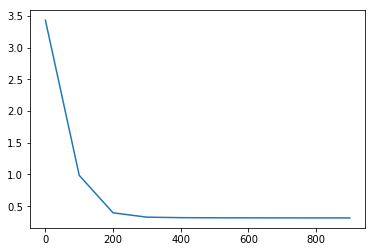

In [15]:
print ('Loss Function Plot:')

plt.plot(iteration_vec, loss_vec)
plt.show()

## Save the Trained Model

One more thing. Let's save the trained model.

In [16]:
saver = tf.train.Saver()
save_path = saver.save(sess, model_file)
print("Model saved in file: %s" % save_path)

Model saved in file: ./model/DeepTabla.ckpt


Phew. That does it for training data and network. Now the fun part. Let's see what all that training produces.

## Restore Previously Trained Model

If steps above are already used, this need not be done. Else restore model.

In [17]:
### Needs work ###

restore = 0

if restore == 1:
    saver.restore(sess, model_file)
    print("Model restored from file: %s" % model_file)

## Set Model to Generate Output

Now that we trained the model, it is time to have it produce the outcome.

In [18]:
LEN = 1;
# XL = tf.placeholder(tf.int32, [None, LEN])
XL     = tf.placeholder(tf.int32, [None, 1])
XL_OH  = tf.one_hot(XL, num_classes)

with tf.variable_scope('CHAR-RNN', reuse=True):
    cell_L = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
    cell_L = rnn.MultiRNNCell([cell_L] * 2, state_is_tuple=True)
    istate = cell_L.zero_state(batch_size=1, dtype=tf.float32)
    # DYNAMIC RNN WITH FULLY CONNECTED LAYER
    _outputs_L, states_L = tf.nn.dynamic_rnn(cell_L, XL_OH
                                , initial_state=istate, dtype=tf.float32)
    _outputs_L  = tf.contrib.layers.fully_connected(
        _outputs_L, num_classes, activation_fn=None)
    # RESHAPE FOR SEQUNCE LOSS
    outputs_L = tf.reshape(_outputs_L, [LEN, 1, num_classes])

print (XL)

Tensor("Placeholder_2:0", shape=(?, 1), dtype=int32)


## Prime the Model

In [19]:
prime = new_cycle

print ('Priming with:', prime)
print ('Dictionary: \n', bols_dic)
print ('Dictionary: \n', char_dic)

prime_set = list(prime.split())

istateval = sess.run(cell_L.zero_state(1, tf.float32))

for i in range(len(prime_set)):
    index = char_dic[prime_set[i]]

    inval = [[index]]
    outval, stateval = sess.run([outputs_L, states_L]
                        , feed_dict={XL:inval, istate:istateval})
    istateval = stateval


Priming with: 26 20 20 26 26 20 20 26 26 24 24 28 28 20 20 26 
Dictionary: 
 {'DhinDhin': 0, 'NaNaNaNa': 1, 'DhaKiTa': 2, 'DhaGeNa': 3, 'DHAKITA': 4, 'Dhinaka': 5, 'DhinaKe': 6, 'DhaDha': 7, 'TinaKa': 8, 'DHADHA': 9, 'NaNaNa': 10, 'TinTin': 11, 'Traka': 12, 'DHAGE': 13, 'DhiNa': 14, 'DhaGe': 15, 'DHINA': 16, 'TraKa': 17, 'NaNa': 18, 'TiTa': 19, 'Dhin': 20, 'NaNA': 21, 'NANA': 22, 'TaTa': 23, 'Tin': 24, 'DHA': 25, 'Dha': 26, 'Na': 27, 'Ta': 28, 'NA': 29, '-': 30}
Dictionary: 
 {'20': 0, '13': 1, '18': 2, '8': 3, '12': 4, '24': 5, '11': 6, '15': 7, '3': 8, '1': 9, '21': 10, '19': 11, '0': 12, '29': 13, '14': 14, '17': 15, '22': 16, '26': 17, '4': 18, '10': 19, '2': 20, '30': 21, '9': 22, '16': 23, '6': 24, '7': 25, '28': 26, '25': 27, '27': 28, '5': 29, '23': 30}


### Generate the Output

Call the primed model to generate output, one bol at a time.

In [20]:
chars = ''
out_sentence = ''

format_output = 0

for i in range(output_length):
    if format_output == 1:
        if i == 0:
            print ('Sampling...')
        elif i%16 == 0 :   # End of one cycle. Print || 
            chars += '||\n'
            out_sentence += '||\n'
        elif i%4 == 0 :    # End of segment. Print |
            chars += '|\t'
            out_sentence += '|\t'


    inval = [[index]]
    outval, stateval = sess.run([outputs_L, states_L]
                        , feed_dict={XL:inval, istate:istateval})
    istateval = stateval
    index = np.argmax(outval)
    char  = char_set[index]
    osen = bols_set[index]

    chars += char+' '
    out_sentence += osen+' '

    print ("[%3d %%] Complete." % (i/output_length*100), end = '\r')

#print ("SAMPLED SENTENCE: \n %s" % (chars))
print ('Generated Output for ', output_length, ' Bols.')

Generated Output for  50000  Bols.


## And.... Wallah....

Finally, the output.

In [21]:
print ("Output Sequence: \n %s" % (out_sentence))

Output Sequence: 
 Dhin Dhin Dha Dha Dhin Dhin DhaDha Dha Dhin Dhin Dha Dha Tin Tin NaNa Ta NaNaNa Dhin Dha Dha Dhin Dhin Dha Dha Dhin Dhin Dha DhaGeNa Tin Tin NaNa Ta DhinDhin Dhin NaNa DHAGE Dhin Dhin Dha NaNa Dhin Dhin Dha Dha Tin Tin Ta Ta Dhin Dhin Dha NA Dhin Dhin Dha DhaGe Dhin Dhin Dha Dha Tin Tin Ta Ta Dhin Dhin Dha DHADHA Dhin Dhin Dha DhaGe DhinaKe - Dha DhaGe Tin Tin Ta Ta Dhin - Dha DHA Traka Dhin Dha Dha Traka DhinDhin Dha Dha Tin Tin Ta NaNaNa Dhin Dhinaka DhaDha DHAGE Traka Dhin Dha Dha Dhin Dhin NaNa DhaGeNa Tin Tin Ta NaNaNa Dhin Dhin Dha DHADHA Dhin Dhin Dha DhaGe Dhin - Dha DhaGeNa Tin Tin TaTa Ta Dhin Dhin Dha DHA Traka Dhin Dha Dha DhinaKe DhinDhin DhaDha Dha Tin Tin Ta NaNaNa DhinDhin Dhin Dha DHADHA Dhin Dhin Dha Dha Dhin - Dha DhaGeNa Tin TinTin Ta Ta Dhin Dhin Dha DHA Traka Dhin Na DhaGe Dhin Dhin DhaDha DhaGeNa Tin Tin Ta NaNA Dhin Dhin NaNa DHADHA Dhin DhinDhin NaNa Dhin Dhin Dhin Dha DhaGeNa Tin TinTin Ta Ta Dhin Dhin Dha DHA Traka Dhin Na DhaGe Dhin Dhin D

Write output to file.

In [22]:
text_file = open(output_file, "w")
text_file.write("%s" % out_sentence)
text_file.close()

print ('Output file written. ', output_file)

Output file written.  ./data/MachineTeentaal.txt


## Analyze the Quality of Output

We need to check how many original ideas the network produced (v/s how many it just copied from the training dataset). This is to figure out if we are overfitting.

In [23]:
s = list(out_sentence.split())

print(len(s))

# identify the position where the first complete cycle starts
for i in range(0,len(out_sentence)): 
    if len(s[i]) >= 2 and s[i][1].isupper():
        found = i
        break

print (found)
s[0:found] = [] # start with first "sam"
print(len(s))

print((len(s)-len(s)%16))

s[((len(s)-len(s)%16)):len(s)] = [] # trim bols after last complete cycle
print(len(s))
del s[((len(s)-len(s)%16)):len(s)]
print(len(s))
print ('Considering ', len(s)/16, ' complete cycles.')


50000
35
49965
49952
49952
49952
Considering  3122.0  complete cycles.


Convert to Pandas Dataframe df1. Remember we loaded training dataset to dataframe df above. 

In [24]:
# convert to Pandas data frame
out_array = np.empty((int(len(s)/16),16),dtype=object)

for i in range(int(len(s)/16)):
    for j in range(16):
        out_array[i,j] = s[i*16+j]

df1 = pd.DataFrame(out_array)
df1.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,DHAGE,Dhin,Dhin,Dha,NaNa,Dhin,Dhin,Dha,Dha,Tin,Tin,Ta,Ta,Dhin,Dhin,Dha
1,NA,Dhin,Dhin,Dha,DhaGe,Dhin,Dhin,Dha,Dha,Tin,Tin,Ta,Ta,Dhin,Dhin,Dha
2,DHADHA,Dhin,Dhin,Dha,DhaGe,DhinaKe,-,Dha,DhaGe,Tin,Tin,Ta,Ta,Dhin,-,Dha
3,DHA,Traka,Dhin,Dha,Dha,Traka,DhinDhin,Dha,Dha,Tin,Tin,Ta,NaNaNa,Dhin,Dhinaka,DhaDha
4,DHAGE,Traka,Dhin,Dha,Dha,Dhin,Dhin,NaNa,DhaGeNa,Tin,Tin,Ta,NaNaNa,Dhin,Dhin,Dha
5,DHADHA,Dhin,Dhin,Dha,DhaGe,Dhin,-,Dha,DhaGeNa,Tin,Tin,TaTa,Ta,Dhin,Dhin,Dha
6,DHA,Traka,Dhin,Dha,Dha,DhinaKe,DhinDhin,DhaDha,Dha,Tin,Tin,Ta,NaNaNa,DhinDhin,Dhin,Dha
7,DHADHA,Dhin,Dhin,Dha,Dha,Dhin,-,Dha,DhaGeNa,Tin,TinTin,Ta,Ta,Dhin,Dhin,Dha
8,DHA,Traka,Dhin,Na,DhaGe,Dhin,Dhin,DhaDha,DhaGeNa,Tin,Tin,Ta,NaNA,Dhin,Dhin,NaNa
9,DHADHA,Dhin,DhinDhin,NaNa,Dhin,Dhin,Dhin,Dha,DhaGeNa,Tin,TinTin,Ta,Ta,Dhin,Dhin,Dha


In [25]:
df1.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122
unique,29,29,29,29,29,29,29,29,29,29,29,30,29,29,29,29
top,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin,Dhin
freq,981,995,1005,964,963,1020,1018,963,943,964,1009,1005,963,982,999,983


In [26]:
s1 = pd.merge(df, df1, how='inner', on=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

if len(s1) == 0:
    print ('Wow, the network produced all original cycles.')
else:
    print ('Network produced the following cycles that were identical in training dataset.')
    print (s1)

Wow, the network produced all original cycles.
